In [2]:
import os
import pandas as pd
import numpy as np
import gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

<h2>Determining optimum number of topics</>

In [4]:

# Function to perform LDA and calculate coherence score
def calculate_coherence_score(dictionary, corpus, texts, num_topics):
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True
    )
    coherence_model_lda = CoherenceModel(
        model=lda_model,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    return coherence_model_lda.get_coherence()

# Directory containing CSV files
data_dir = r"D:\Research\Python\Data\WIP\Spike Data"

# Load CSV files into dataframes and process each dataset
results = []
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        dataset_name = os.path.splitext(filename)[0]
        dataset_path = os.path.join(data_dir, filename)

        # Load data into dataframe
        df = pd.read_csv(dataset_path)
        # Handle missing values in the 'Text_Lemmatized' column
        df['Text_Lemmatized'] = df['Text_Lemmatized'].apply(lambda x: x if pd.notnull(x) else '')

        # Convert the 'Text_Lemmatized' column back to lists of words
        df['Text_Lemmatized'] = df['Text_Lemmatized'].apply(lambda x: x.split())

        # Create a Gensim dictionary from the lemmatized text
        dictionary = Dictionary(df['Text_Lemmatized'])

        # Create a Gensim corpus
        corpus = [dictionary.doc2bow(text) for text in df['Text_Lemmatized']]

        # List to store coherence scores for different number of topics
        coherence_scores = []

        # Determine the most appropriate number of topics (1 to 10)
        for num_topics in range(1, 11):
            coherence_score = calculate_coherence_score(dictionary, corpus, df['Text_Lemmatized'], num_topics)
            coherence_scores.append(coherence_score)

        # Store the results for the current dataset
        result_row = [dataset_name]
        for num_topics, coherence_score in enumerate(coherence_scores, start=1):
            result_row.append(coherence_score)

        results.append(result_row)

# Create a dataframe to store the results
columns = ['Dataset'] + [f"Topic_{i}_Coherence" for i in range(1, 11)]
results_df = pd.DataFrame(results, columns=columns)

# Save the results to CSV
output_dir = r"D:\Research\Python\Data\WIP\Topic modelling"
output_file = os.path.join(output_dir, "LDA_Topic_modelling_Scores.csv")
results_df.to_csv(output_file, index=False)

# Print the best number of topics for each dataset
for idx, row in results_df.iterrows():
    dataset_name = row['Dataset']
    best_num_topics = np.argmax(row[1:]) + 1
    print(f"{dataset_name}: Best number of topics = {best_num_topics}")

2021-01-07_spike_data: Best number of topics = 2
2021-04-07_spike_data: Best number of topics = 3
2021-05-06_spike_data: Best number of topics = 10
2021-06-06_spike_data: Best number of topics = 3
2021-06-07_spike_data: Best number of topics = 2
2021-10-31_spike_data: Best number of topics = 9
2021-11-11_spike_data: Best number of topics = 1
2022-02-09_spike_data: Best number of topics = 1
2022-02-10_spike_data: Best number of topics = 10
2022-03-06_spike_data: Best number of topics = 9
2022-03-27_spike_data: Best number of topics = 9


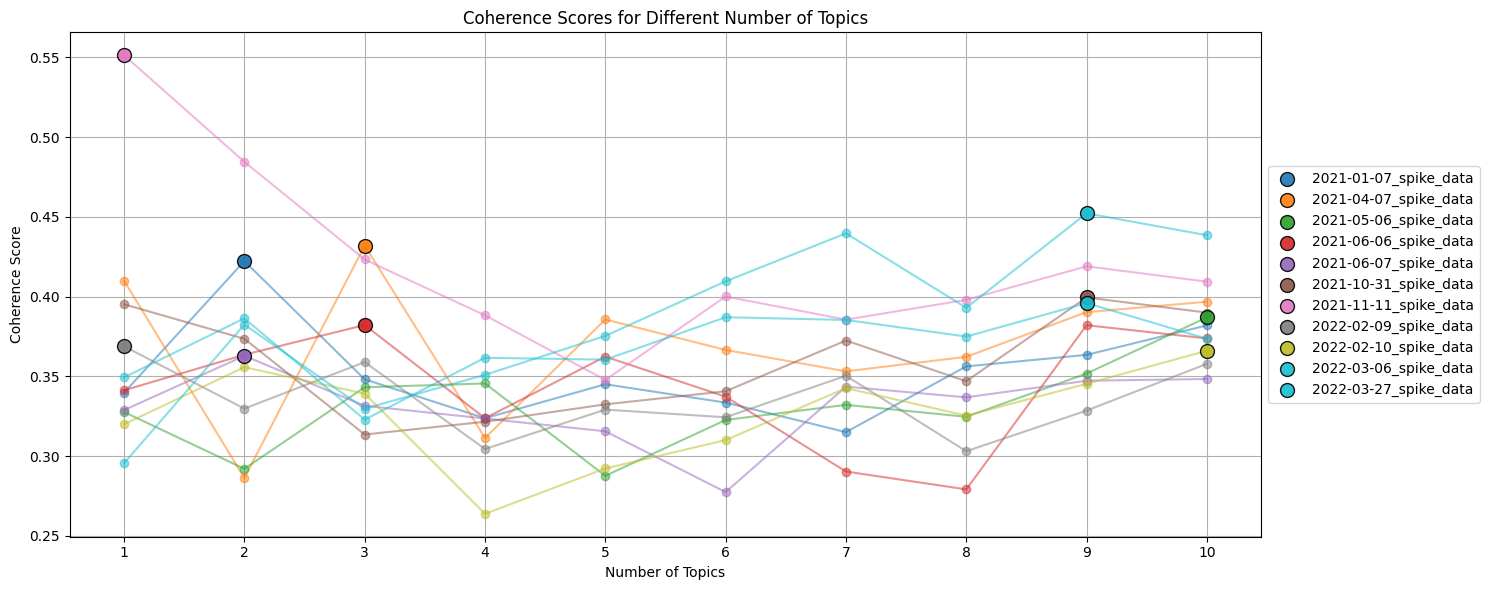

In [3]:

import matplotlib.pyplot as plt

results_dir = r"D:\Research\Python\Data\WIP\Topic modelling"
result_file = os.path.join(results_dir, "LDA_Topic_modelling_Scores.csv")

# Load the results from the CSV file
results_df = pd.read_csv(result_file)

# Separate the dataset names from the coherence scores
dataset_names = results_df['Dataset']
coherence_scores = results_df.iloc[:, 1:]

# Plot the coherence scores for each dataset
plt.figure(figsize=(15, 6))

# Define colors for each dataset's line plot
colors = plt.cm.tab10(np.linspace(0, 1, len(dataset_names)))

# Plot the coherence scores as lines on the graph, reducing the alpha
for idx, dataset_name in enumerate(dataset_names):
    plt.plot(range(1, 11), coherence_scores.iloc[idx], marker='o', color=colors[idx], alpha=0.5, label=None)

# Highlight the highest coherence score for each dataset with increased alpha
for idx, dataset_name in enumerate(dataset_names):
    best_num_topics = np.argmax(coherence_scores.iloc[idx]) + 1
    best_coherence_score = coherence_scores.iloc[idx, best_num_topics - 1]
    plt.scatter(best_num_topics, best_coherence_score, s=100, color=colors[idx], edgecolors='black', alpha=0.9, zorder=5, label=dataset_names[idx])

plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores for Different Number of Topics')
plt.xticks(range(1, 11))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(True)
plt.tight_layout()

# Save the plot to a file (optional)
plot_output_file = os.path.join(results_dir, "coherence_scores_plot.png")
plt.savefig(plot_output_file)

# Show the plot
plt.show()


<h2>Topic Extraction</>

In [9]:

data_dir = r"D:\Research\Python\Data\WIP\Spike Data"
output_dir = r"D:\Research\Python\Data\WIP\Topic modelling"

# Load the previous results CSV to get the best number of topics for each dataset
results_df = pd.read_csv(result_file)


# Create an empty DataFrame to accumulate all top topics
all_top_topics_df = pd.DataFrame(columns=['Dataset', 'Best_Num_Topics', 'Topic', 'Words'])

# Print the best number of topics and extract top topics for each dataset
for idx, row in results_df.iterrows():
    dataset_name = row['Dataset']
    best_num_topics = np.argmax(row[1:]) + 1
    print(f"{dataset_name}: Best number of topics = {best_num_topics}")

    # Load the dataset CSV
    dataset_path = os.path.join(data_dir, f"{dataset_name}.csv")
    df = pd.read_csv(dataset_path)

    # Handle missing values in the 'Text_Lemmatized' column
    df['Text_Lemmatized'] = df['Text_Lemmatized'].apply(lambda x: x if pd.notnull(x) else '')

    # Convert the 'Text_Lemmatized' column back to lists of words
    df['Text_Lemmatized'] = df['Text_Lemmatized'].apply(lambda x: x.split())


    # Create a Gensim dictionary from the lemmatized text
    dictionary = Dictionary(df['Text_Lemmatized'])
    corpus = [dictionary.doc2bow(text) for text in df['Text_Lemmatized']]

    # Run LDA again with the best number of topics for this dataset
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=best_num_topics,
        random_state=42,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True
    )

    # Extract the top topics for this dataset
    top_topics = lda_model.show_topics(formatted=False, num_topics=best_num_topics)

    # Convert the list of tuples into a space-separated string of words
    def format_topic_words(topic_words):
        return ' '.join([word for word, _ in topic_words])

    # Create a DataFrame for the top topics of this dataset
    top_topics_df = pd.DataFrame(top_topics, columns=['Topic', 'Words'])
    top_topics_df['Words'] = top_topics_df['Words'].apply(format_topic_words)  # Convert to space-separated string
    top_topics_df['Dataset'] = dataset_name
    top_topics_df['Best_Num_Topics'] = best_num_topics

    # Concatenate the DataFrame to the all_top_topics_df DataFrame
    all_top_topics_df = pd.concat([all_top_topics_df, top_topics_df], ignore_index=True)

# Save all top topics to a single CSV file
all_topics_output_file = os.path.join(output_dir, "LDA_Topics_Per_Each_Dataset.csv")
all_top_topics_df.to_csv(all_topics_output_file, index=False)


2021-01-07_spike_data: Best number of topics = 2
2021-04-07_spike_data: Best number of topics = 3
2021-05-06_spike_data: Best number of topics = 10
2021-06-06_spike_data: Best number of topics = 3
2021-06-07_spike_data: Best number of topics = 2
2021-10-31_spike_data: Best number of topics = 9
2021-11-11_spike_data: Best number of topics = 1
2022-02-09_spike_data: Best number of topics = 1
2022-02-10_spike_data: Best number of topics = 10
2022-03-06_spike_data: Best number of topics = 9
2022-03-27_spike_data: Best number of topics = 9
